<h1>Generalized Linear Models, and Poisson loss for gradient boosting</h1>
Source: https://scikit-learn.org/stable/auto_examples/release_highlights/plot_release_highlights_0_23_0.html

Long-awaited Generalized Linear Models with non-normal loss functions are now available. In particular, three new regressors were implemented: PoissonRegressor, GammaRegressor, and TweedieRegressor. The Poisson regressor can be used to model positive integer counts, or relative frequencies. Read more in the User Guide. Additionally, HistGradientBoostingRegressor supports a new ‘poisson’ loss as well.

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PoissonRegressor
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor

n_samples, n_features = 1000, 20
rng = np.random.RandomState(0)
X = rng.randn(n_samples, n_features)
# positive integer target correlated with X[:, 5] with many zeros:
y = rng.poisson(lam=np.exp(X[:, 5]) / 2)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rng)
glm = PoissonRegressor()
gbdt = HistGradientBoostingRegressor(loss='poisson', learning_rate=.01)
glm.fit(X_train, y_train)
gbdt.fit(X_train, y_train)
print(glm.score(X_test, y_test))
print(gbdt.score(X_test, y_test))

0.35776189065725783
0.42425183539869415


<h2>Rich visual representation of estimators</h2>

Estimators can now be visualized in notebooks by enabling the display='diagram' option.

This is particularly useful to summarise the structure of pipelines and other composite estimators, with interactivity to provide detail. 
Click on the example image below to expand Pipeline elements. See Visualizing Composite Estimators for how you can use this feature.

In [1]:
import sklearn
sklearn.__version__

'0.23.1'

In [7]:
from sklearn import set_config
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
set_config(display='diagram')

num_proc = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())

cat_proc = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='missing'),
    OneHotEncoder(handle_unknown='ignore'))

preprocessor = make_column_transformer((num_proc, ('feat1', 'feat3')),
                                       (cat_proc, ('feat0', 'feat2')))

clf = make_pipeline(preprocessor, LogisticRegression())
clf

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ('feat1', 'feat3')),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ('feat0', 'feat2'))])),
                ('logisticregression', LogisticRegression())])

<h2>Scalability and stability improvements to KMeans</h2>

The KMeans estimator was entirely re-worked, and it is now significantly faster and more stable. In addition, the Elkan algorithm is now compatible with sparse matrices. The estimator uses OpenMP based parallelism instead of relying on joblib, so the n_jobs parameter has no effect anymore. For more details on how to control the number of threads, please refer to our Parallelism notes.

In [9]:
import scipy
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import completeness_score

rng = np.random.RandomState(0)
X, y = make_blobs(random_state=rng)
X = scipy.sparse.csr_matrix(X)
X_train, X_test, _, y_test = train_test_split(X, y, random_state=rng)
kmeans = KMeans(algorithm='elkan').fit(X_train)
print(completeness_score(kmeans.predict(X_test), y_test))

0.7065833376318835


<h2>Improvements to the histogram-based Gradient Boosting estimators</h2>
Various improvements were made to <b>HistGradientBoostingClassifier</b> and <b>HistGradientBoostingRegressor</b>. On top of the Poisson loss mentionned above, these estimators now support sample weights. Also, an automatic early-stopping criterion was added: early-stopping is enabled by default when the number of samples exceeds 10k. Finally, users can now define monotonic constraints to constrain the predictions based on the variations of specific features. In the following example, we construct a target that is generally positively correlated with the first feature, with some noise. Applying monotoinc constraints allows the prediction to capture the global effect of the first feature, instead of fitting the noise.

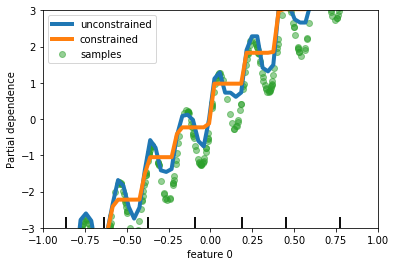

In [11]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.inspection import plot_partial_dependence
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor

n_samples = 500
rng = np.random.RandomState(0)
X = rng.randn(n_samples, 2)
noise = rng.normal(loc=0.0, scale=0.01, size=n_samples)
y = (5 * X[:, 0] + np.sin(10 * np.pi * X[:, 0]) - noise)

gbdt_no_cst = HistGradientBoostingRegressor().fit(X, y)
gbdt_cst = HistGradientBoostingRegressor(monotonic_cst=[1, 0]).fit(X, y)

disp = plot_partial_dependence(
    gbdt_no_cst, X, features=[0], feature_names=['feature 0'],
    line_kw={'linewidth': 4, 'label': 'unconstrained'})
plot_partial_dependence(gbdt_cst, X, features=[0],
    line_kw={'linewidth': 4, 'label': 'constrained'}, ax=disp.axes_)
disp.axes_[0, 0].plot(X[:, 0], y, 'o', alpha=.5, zorder=-1, label='samples')
disp.axes_[0, 0].set_ylim(-3, 3); disp.axes_[0, 0].set_xlim(-1, 1)
plt.legend()
plt.show()

<h2>Sample-weight support for Lasso and ElasticNet</h2>

The two linear regressors Lasso and ElasticNet now support sample weights.

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.linear_model import Lasso
import numpy as np

n_samples, n_features = 1000, 20
rng = np.random.RandomState(0)
X, y = make_regression(n_samples, n_features, random_state=rng)
sample_weight = rng.rand(n_samples)
X_train, X_test, y_train, y_test, sw_train, sw_test = train_test_split(
    X, y, sample_weight, random_state=rng)
reg = Lasso()
reg.fit(X_train, y_train, sample_weight=sw_train)
print(reg.score(X_test, y_test, sw_test))

0.999791942438998
